Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 Conteo de imágenes por conjunto:

train: 6197 imágenes
valid: 1766 imágenes
test: 883 imágenes


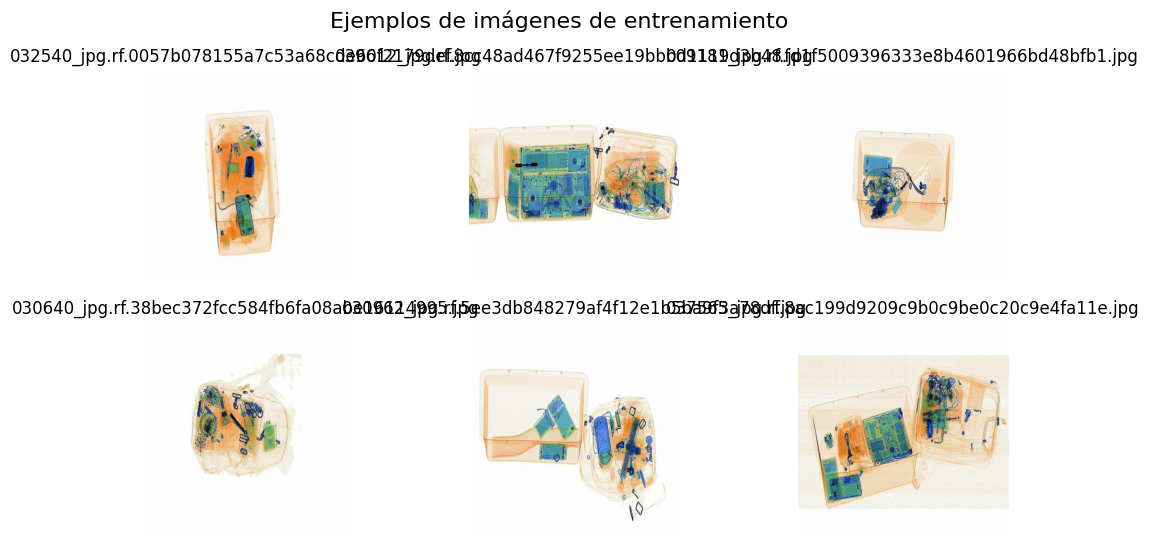


Total de imágenes (train): 6197
Total de etiquetas (train): 6181

Vista previa de las anotaciones:
                                              imagen  clase         x  \
0  009000_jpg.rf.8c46e1aa5b46a0ad24ee4bcb2945d22a...      2  0.653846   
1  009002_jpg.rf.18bf80f2cfdb51f853da15019f787cef...      2  0.557692   
2  009003_jpg.rf.46963402c4cb6f46a47e508b892c6521...      2  0.423077   
3  009007_jpg.rf.a5143afbb0c741f3b60fc72403fdde6a...      2  0.401442   
4  009012_jpg.rf.bc99877ade8754d2be89119361e7820c...      2  0.804087   

          y     ancho      alto  
0  0.542067  0.062500  0.066106  
1  0.338942  0.055288  0.070913  
2  0.379808  0.099760  0.055288  
3  0.350962  0.055288  0.177885  
4  0.387019  0.052885  0.072115  


/tmp/ipython-input-3069468171.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="clase", data=df, palette="viridis")


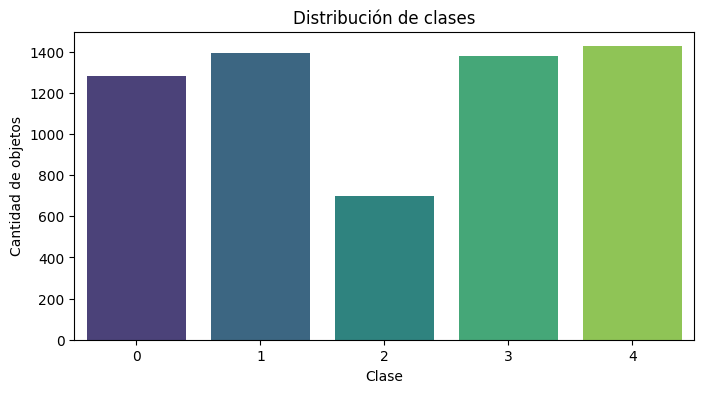

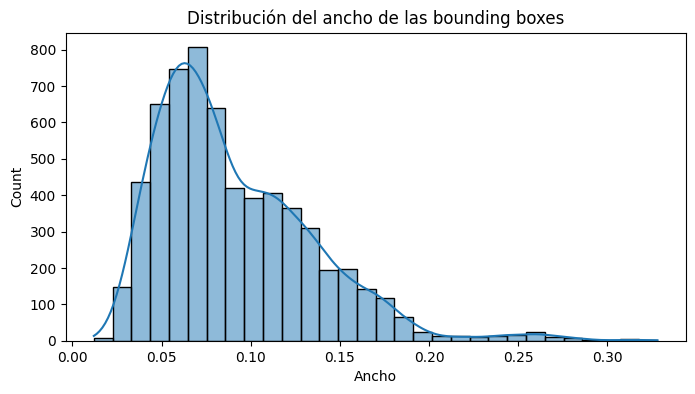

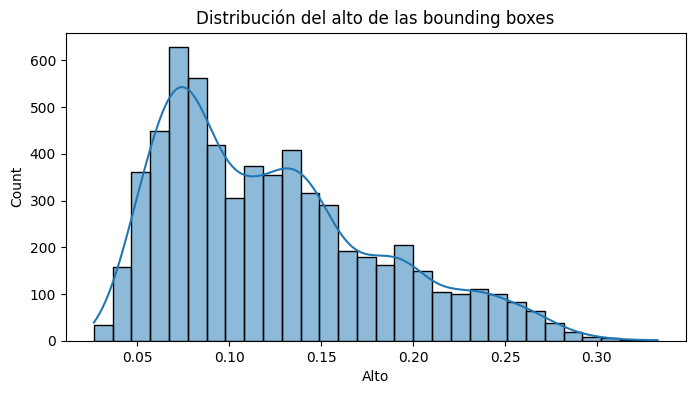

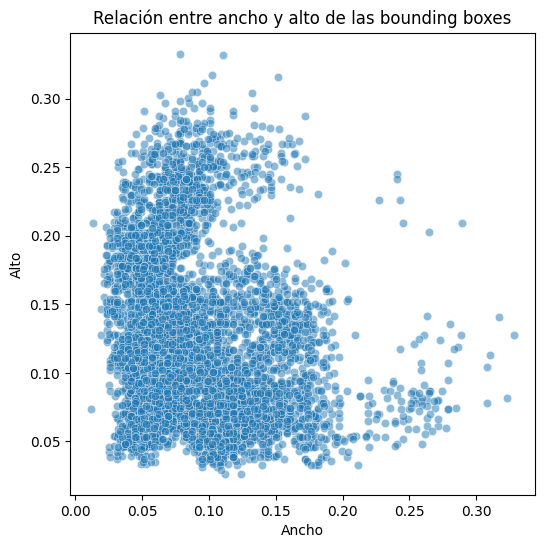


📈 Resumen estadístico de las cajas:
             ancho         alto
count  6181.000000  6181.000000
mean      0.090867     0.123576
std       0.044046     0.058858
min       0.012019     0.026442
25%       0.057692     0.075721
50%       0.080529     0.111779
75%       0.116587     0.157452
max       0.328125     0.332933


In [ ]:
# ================================================================
# EDA - X-Ray Baggage Scanner Anomaly Detection
# ================================================================

import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from google.colab import drive

# ===========================
# Montar Google Drive
# ===========================
drive.mount('/content/drive')

# ===========================
# Rutas base
# ===========================
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner")
SPLITS = ["train", "valid", "test"]

# ===========================
# Conteo de imágenes por split
# ===========================
print("📊 Conteo de imágenes por conjunto:\n")
for s in SPLITS:
    imgs = list((BASE_DIR / s / "images").rglob("*.jpg")) + list((BASE_DIR / s / "images").rglob("*.png"))
    print(f"{s}: {len(imgs)} imágenes")

# ===========================
# Mostrar ejemplos aleatorios (train)
# ===========================
train_imgs = list((BASE_DIR / "train" / "images").rglob("*.jpg"))
sample_imgs = random.sample(train_imgs, min(6, len(train_imgs)))

plt.figure(figsize=(12, 6))
for i, img_path in enumerate(sample_imgs):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(Path(img_path).name)
    plt.axis("off")
plt.suptitle("Ejemplos de imágenes de entrenamiento", fontsize=16)
plt.show()

# ===========================
# Lectura de etiquetas YOLO
# ===========================
IMAGES_DIR = BASE_DIR / "train" / "images"
LABELS_DIR = BASE_DIR / "train" / "labels"

images = sorted(os.listdir(IMAGES_DIR))
labels = sorted(os.listdir(LABELS_DIR))

print(f"\nTotal de imágenes (train): {len(images)}")
print(f"Total de etiquetas (train): {len(labels)}")

# Función para parsear las etiquetas YOLO (formato: class x_center y_center width height)
def parse_label(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()
    data = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            cls, x, y, w, h = map(float, parts)
            data.append([int(cls), x, y, w, h])
    return data

# ===========================
# Crear dataframe con todas las anotaciones
# ===========================
all_data = []
for lbl_file in labels:
    file_path = os.path.join(LABELS_DIR, lbl_file)
    img_name = lbl_file.replace(".txt", ".jpg")
    annotations = parse_label(file_path)
    for ann in annotations:
        cls, x, y, w, h = ann
        all_data.append([img_name, cls, x, y, w, h])

df = pd.DataFrame(all_data, columns=["imagen", "clase", "x", "y", "ancho", "alto"])
print("\nVista previa de las anotaciones:")
print(df.head())

# ===========================
# Análisis de distribución de clases
# ===========================
plt.figure(figsize=(8, 4))
sns.countplot(x="clase", data=df, palette="viridis")
plt.title("Distribución de clases")
plt.xlabel("Clase")
plt.ylabel("Cantidad de objetos")
plt.show()

# ===========================
# Análisis de tamaños de bounding boxes
# ===========================
plt.figure(figsize=(8, 4))
sns.histplot(df["ancho"], bins=30, kde=True)
plt.title("Distribución del ancho de las bounding boxes")
plt.xlabel("Ancho")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df["alto"], bins=30, kde=True)
plt.title("Distribución del alto de las bounding boxes")
plt.xlabel("Alto")
plt.show()

# ===========================
# Relación entre ancho y alto
# ===========================
plt.figure(figsize=(6, 6))
sns.scatterplot(x="ancho", y="alto", data=df, alpha=0.5)
plt.title("Relación entre ancho y alto de las bounding boxes")
plt.xlabel("Ancho")
plt.ylabel("Alto")
plt.show()

# ===========================
# Resumen estadístico
# ===========================
print("\n📈 Resumen estadístico de las cajas:")
print(df[["ancho", "alto"]].describe())


In [ ]:
# Instalar dependencias
import torch
print("Torch:", torch.__version__, " | CUDA disponible:", torch.cuda.is_available())


Torch: 2.8.0+cu126  | CUDA disponible: True


In [ ]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
# Definir ruta del data set
DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner')

print("Existe:", DATA_DIR.exists())

# Listar contenido
!ls -lha "/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Existe: True
total 14K
-rw------- 1 root root  364 Nov  5 17:10 data.yaml
-rw------- 1 root root  160 Apr 12  2025 README.dataset.txt
-rw------- 1 root root 1006 Apr 12  2025 README.roboflow.txt
drwx------ 4 root root 4.0K Nov  2 15:10 test
drwx------ 4 root root 4.0K Nov  2 15:10 train
drwx------ 4 root root 4.0K Nov  2 15:10 valid


In [ ]:
# Verificar estructura y actualizar data.yaml
import yaml

yaml_path = DATA_DIR / "data.yaml"

with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)

data["path"] = str(DATA_DIR)

with open(yaml_path, "w") as f:
    yaml.dump(data, f)

print("data.yaml actualizado:")
print(data)



data.yaml actualizado:
{'names': ['0', '1', '2', '3', '4'], 'nc': 5, 'path': '/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner', 'roboflow': {'license': 'CC BY 4.0', 'project': 'x-ray-baggage-detection', 'url': 'https://universe.roboflow.com/malek-mhnrl/x-ray-baggage-detection/dataset/1', 'version': 1, 'workspace': 'malek-mhnrl'}, 'test': '../test/images', 'train': '../train/images', 'val': '../valid/images'}


Imágenes en train: 6197
Usando imagen de ejemplo: /content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner/train/images/037386_jpg.rf.7d6fea56091733f18e0cdfeda87f04f1.jpg


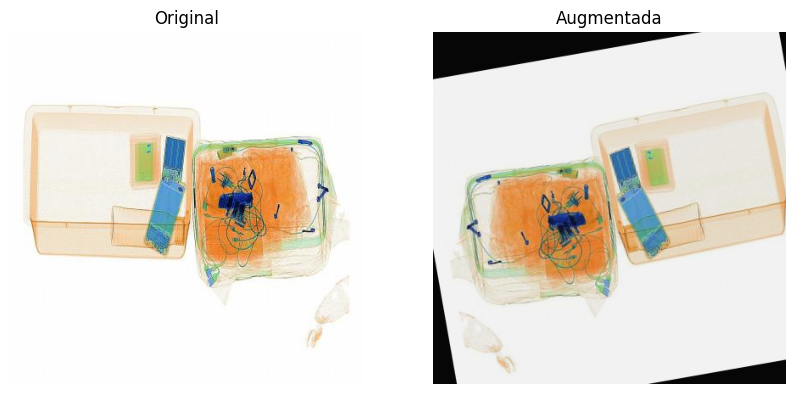

In [ ]:
# Data augmentation + manejo de errores
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Buscar imágenes en train/valid/test (si no existe sample_imgs)
DATA_DIR = Path('/content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner')

train_images = list((DATA_DIR / "train" / "images").rglob("*.jpg")) + list((DATA_DIR / "train" / "images").rglob("*.png"))

print("Imágenes en train:", len(train_images))
if len(train_images) == 0:
    # fallback: buscar en todo el dataset
    all_imgs = list(DATA_DIR.rglob("*.jpg")) + list(DATA_DIR.rglob("*.png"))
    print("Imágenes totales encontradas (fallback):", len(all_imgs))
    if len(all_imgs) == 0:
        raise RuntimeError("No se encontraron imágenes en el dataset. Revisá DATA_DIR.")
    sample_img_path = str(all_imgs[0])
else:
    sample_img_path = str(random.choice(train_images))

print("Usando imagen de ejemplo:", sample_img_path)

# Defino augmentaciones válidas (sin parámetros inválidos)
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(translate_percent=0.03, scale=(0.92, 1.08), rotate=10, p=0.6),  # reemplaza ShiftScaleRotate
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
    A.Blur(blur_limit=3, p=0.2),
    A.CoarseDropout(p=0.2),  # simple, sin params que provoquen warning
])

# Leer imagen (cv2 devuelve BGR)
img = cv2.imread(sample_img_path)
if img is None:
    raise RuntimeError(f"No se pudo leer la imagen: {sample_img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Aplicar augment y mostrar
augmented = aug(image=img)['image']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Augmentada")
plt.imshow(augmented)
plt.axis("off")
plt.show()



In [ ]:
# =======================
# ENTRENAMIENTO YOLOv8
# =======================

!pip install ultralytics -q

from ultralytics import YOLO
from pathlib import Path
import shutil
import torch
from google.colab import drive
import os
import glob

# ===========================
# Montar Google Drive
# ===========================
drive.mount('/content/drive')

# ===========================
# Configuración de rutas
# ===========================
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks")
DATA_DIR = BASE_DIR / "dataset_baggage_scanner"
MODEL_DIR = BASE_DIR / "modelos"
MODEL_PATH = MODEL_DIR / "baggage_yolov8n_debug.pt"
RUNS_DIR = BASE_DIR / "runs/train/baggage_yolov8n_debug"
LOCAL_DATA = Path("/content/dataset_baggage_scanner")

# ===========================
# Verificar GPU
# ===========================
print("GPU disponible:", torch.cuda.is_available())
print("Dispositivo:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

if not torch.cuda.is_available():
    print("No tenés GPU activada. Andá a 'Entorno de ejecución → Cambiar tipo de entorno de ejecución' y elegí GPU antes de continuar.")
else:
    print("Entrenamiento acelerado por GPU listo.")

# ===========================
# Copiar dataset local
# ===========================
if not LOCAL_DATA.exists():
    shutil.copytree(DATA_DIR, LOCAL_DATA)
    print("Dataset copiado a almacenamiento local.")
else:
    print("Dataset ya presente en almacenamiento local.")

# ===========================
# Cargar o entrenar modelo
# ===========================
if MODEL_PATH.exists():
    print(f"Modelo encontrado en {MODEL_PATH}, cargando sin entrenar...")
    model = YOLO(MODEL_PATH)
else:
    print("No se encontró modelo entrenado, iniciando entrenamiento...")

    # Borrar runs anteriores para que no duplique nombres
    if RUNS_DIR.exists():
        shutil.rmtree(RUNS_DIR)

    model = YOLO("yolov8n.pt")  # modelo base pequeño

    results = model.train(
        data=str(LOCAL_DATA / "data.yaml"),
        epochs=50,
        imgsz=640,
        batch=8,
        name="baggage_yolov8n_debug",
        project=str(BASE_DIR / "runs/train"),  # carpeta fija
        exist_ok=True,  # evita crear baggage_yolov8n_debug2, etc.
        device=0  # fuerza uso de GPU
    )

    # ==============================
    # Guardar el mejor modelo
    # ==============================
    best_model = RUNS_DIR / "weights" / "best.pt"
    if best_model.exists():
        MODEL_DIR.mkdir(parents=True, exist_ok=True)
        shutil.copy(best_model, MODEL_PATH)
        print(f"Modelo copiado y guardado en: {MODEL_PATH}")
    else:
        print("No se encontró el archivo best.pt luego del entrenamiento.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU disponible: True
Dispositivo: Tesla T4
Entrenamiento acelerado por GPU listo.
Dataset ya presente en almacenamiento local.
Modelo encontrado en /content/drive/MyDrive/Colab Notebooks/modelos/baggage_yolov8n_debug.pt, cargando sin entrenar...


In [ ]:
# Evaluación del modelo
metrics = model.val(data=str(DATA_DIR / "data.yaml"), imgsz=640)
print("📊 Métricas finales:")
print(metrics)


Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.7 ms, read: 7.3±4.2 MB/s, size: 19.4 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/dataset_baggage_scanner/valid/labels.cache... 1766 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1766/1766 235.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 111/111 3.0it/s 37.2s
                   all       1766       1766      0.618      0.536      0.561      0.236
                     0        391        391      0.727      0.839      0.825      0.369
                     1        389        389      0.689      0.512      0.609       0.25
                     2        225        225       0.59     0.0844      0.164     0.0522
                     3        366        366      0.554      0.399      0.441      0.187
 

Resultados del entrenamiento cargados correctamente 

   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  164.048         2.23275         4.04060         1.72445   
1      2  317.594         2.04969         2.53541         1.62296   
2      3  474.337         2.02802         2.20098         1.62119   
3      4  626.767         1.99026         2.01985         1.61444   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.40478            0.40495           0.35966   
1               0.61136            0.46633           0.46870   
2               0.55437            0.51780           0.51676   
3               0.61805            0.53634           0.55976   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.13469       2.02916       2.26838       1.79399  0.000370   
1              0.18386       1.96829       1.99627       1.73265  0.000726   
2              0.20607       1.98901       1.

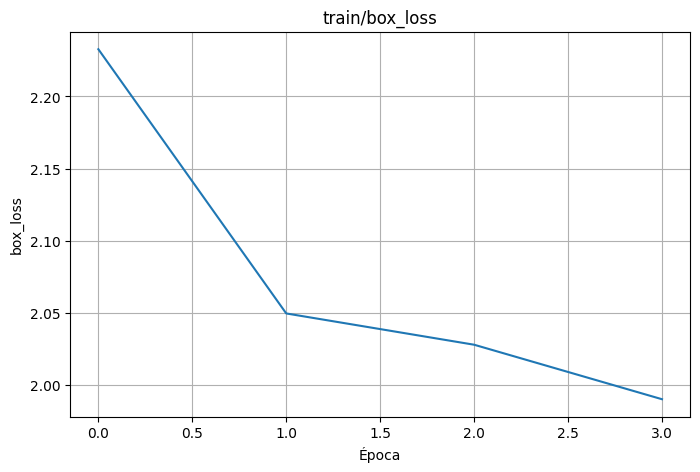

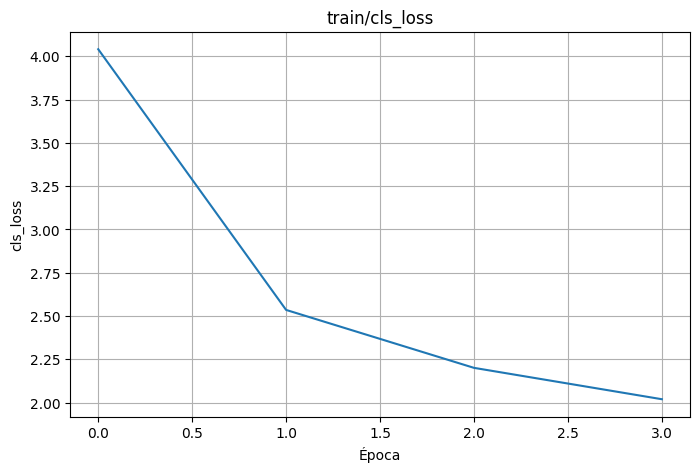

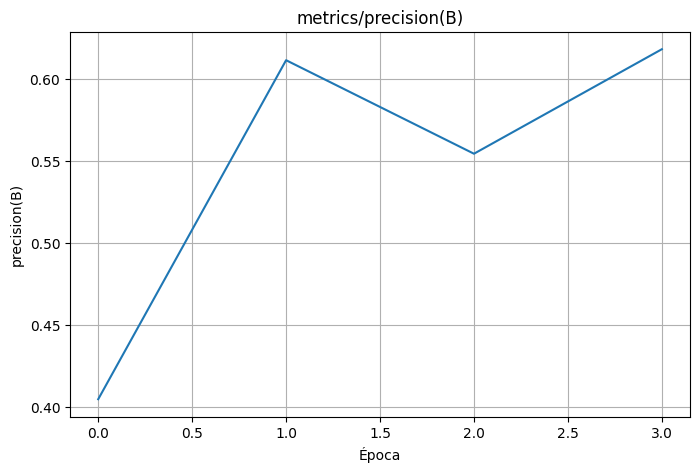

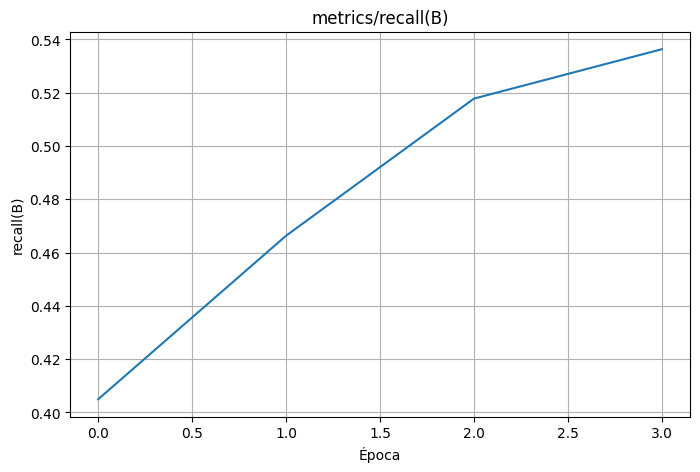

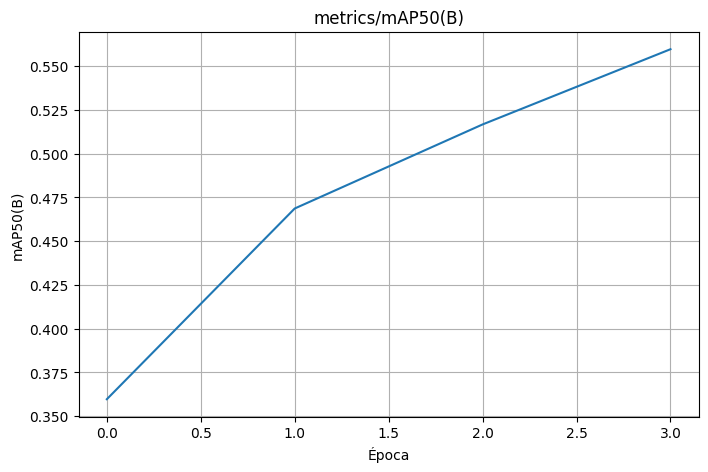

In [ ]:
# ======================================================
# VISUALIZAR RESULTADOS DEL ENTRENAMIENTO (vía CSV)
# ======================================================
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ruta al CSV de resultados
exp_dir = "/content/drive/MyDrive/Colab Notebooks/runs/baggage_yolov8n_debug"
csv_path = os.path.join(exp_dir, "results.csv")

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print("Resultados del entrenamiento cargados correctamente \n")
    print(df.head())

    # --- Graficar pérdidas y métricas ---
    metrics = ['train/box_loss', 'train/cls_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)']
    for metric in metrics:
        if metric in df.columns:
            plt.figure(figsize=(8, 5))
            plt.plot(df.index, df[metric])
            plt.title(metric)
            plt.xlabel("Época")
            plt.ylabel(metric.split('/')[-1])
            plt.grid(True)
            plt.show()
else:
    print("No se encontró results.csv — ejecutá el entrenamiento primero.")




In [ ]:
# Experimentos propuestos
# Propuesta de 4 entrenamientos (solo texto explicativo):

experimentos = {
    "EXP1": "YOLOv8n - 10 epochs - subset - baseline rápido",
    "EXP2": "YOLOv8s - 100 epochs - full dataset - augment moderado",
    "EXP3": "YOLOv8s - 100 epochs - sin augment - comparación",
    "EXP4": "Faster-RCNN ResNet50 FPN - pretrained COCO - 30 epochs"
}

for k,v in experimentos.items():
    print(f"{k}: {v}")



EXP1: YOLOv8n - 10 epochs - subset - baseline rápido
EXP2: YOLOv8s - 100 epochs - full dataset - augment moderado
EXP3: YOLOv8s - 100 epochs - sin augment - comparación
EXP4: Faster-RCNN ResNet50 FPN - pretrained COCO - 30 epochs


In [ ]:
# Guardar pesos y resultado en Drive
!cp -r /content/runs /content/drive/MyDrive/Colab\ Notebooks/
print("Resultados copiados a Drive en Colab Notebooks/runs/")




Resultados copiados a Drive en Colab Notebooks/runs/
